This jupyter notebook demonstrates a method of getting the map and GPS coordinates for a point in an IFC model.
The model contains a single sign at the intersection of NE Bothell Way and 80th Ave NE. The example sign was selected from the image below, which I screen captured during one of our ADCMS grant project meetings.

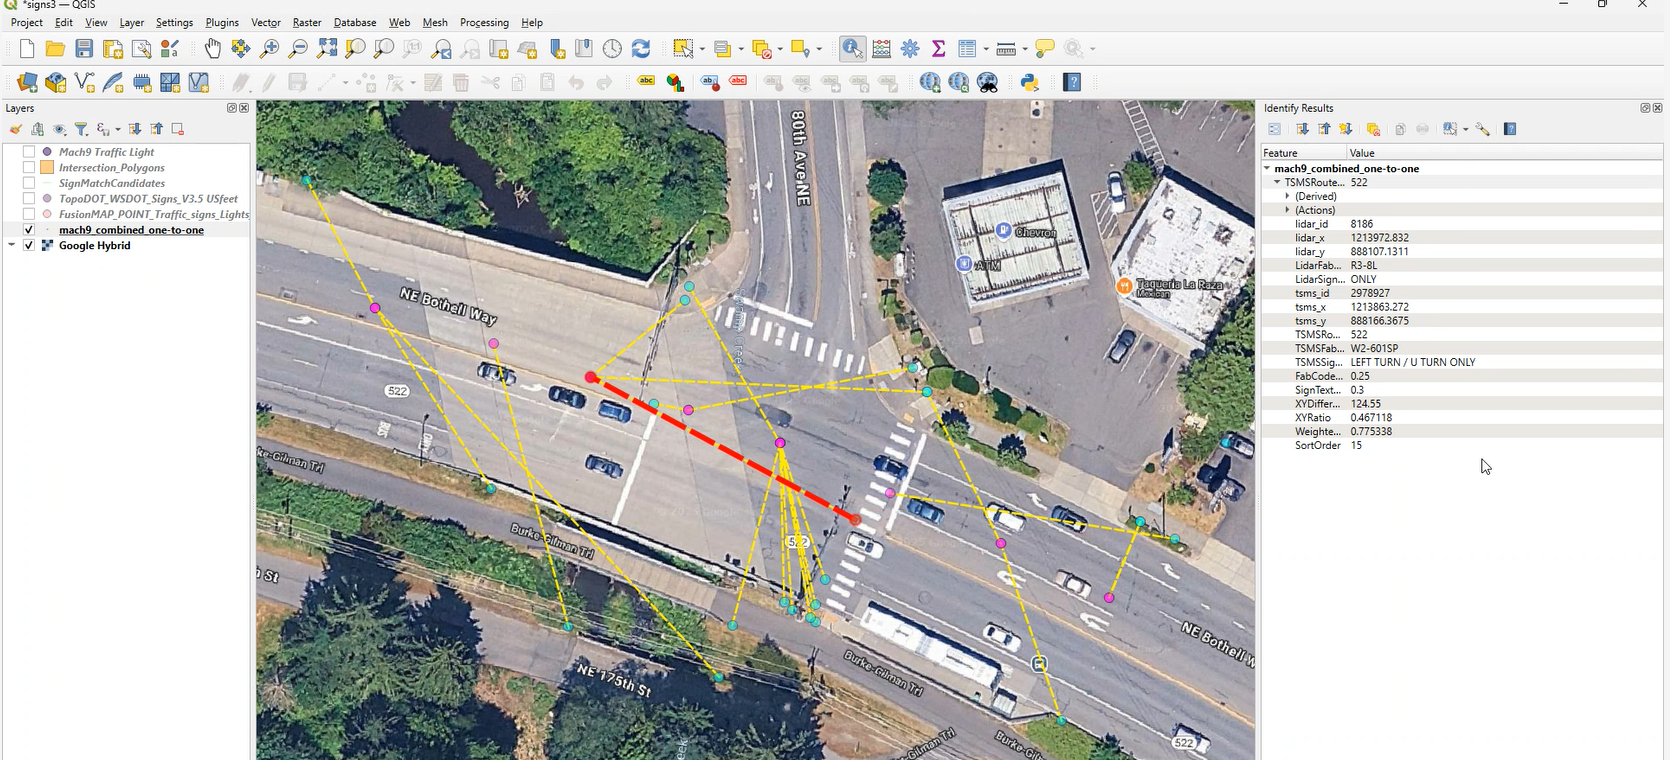

Lidar has the sign located at (1213972.831863016,888107.1310520759) and identifies it as R3-8L with sign face text "Only". From the lidar data, the OBJECT ID for this sign is 1127.

I think the example sign is the U-turn sign in this image
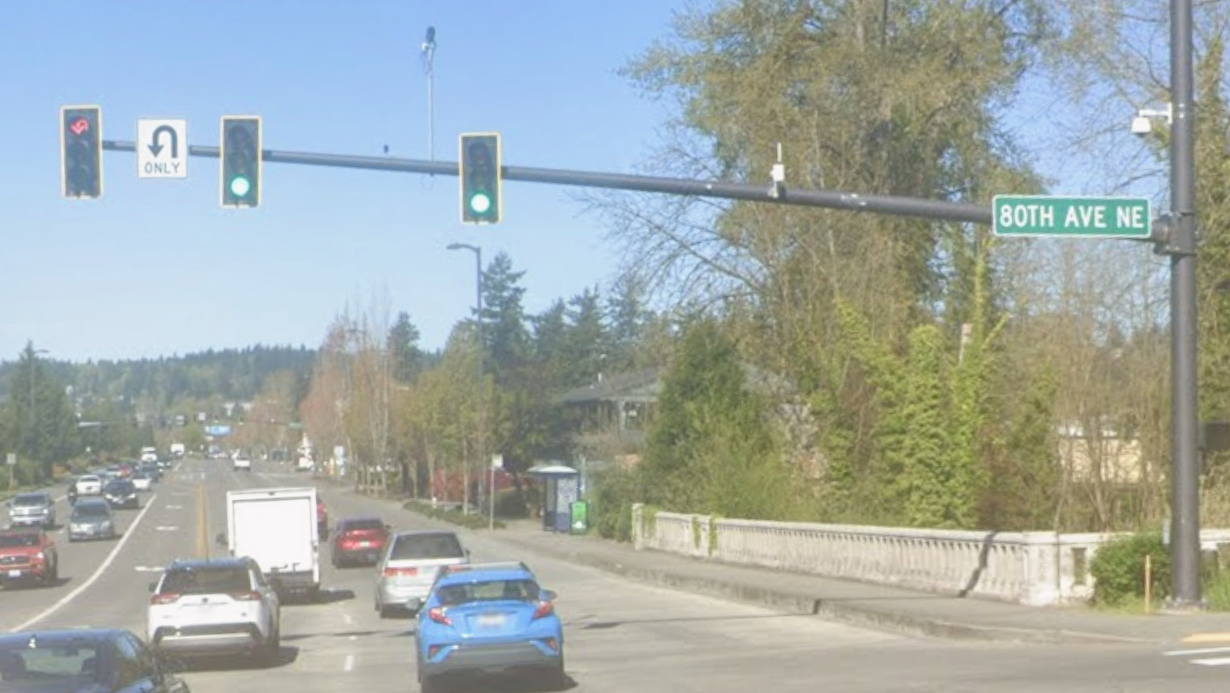

The street sign for 80th Ave NE has ObjectID 998 and is located at (1213902.309165058,888198.0856182049), which is very close to the example sign. This provides confidence in the location of the example sign.

In [7]:
import ifcopenshell
import ifcopenshell.api.context
import ifcopenshell.api.unit
import ifcopenshell.api.georeference
import math
from pyproj import Transformer

# load IFC model
model = ifcopenshell.open("C:/Users/bricer/OneDrive - Washington State Department of Transportation/Desktop/GeolocatedSign.ifc")

# Get the sign
sign = model.by_type("IfcSign")[0]

# Get the placement of the sign in the engineering coordinate system
m = ifcopenshell.util.placement.get_local_placement(sign.ObjectPlacement)
x = m[0][3]
y = m[1][3]
z = m[2][3]
print(f"Sign location in project coordinates: {x},{y},{z}")


Sign location in project coordinates: 0.0,0.0,0.0


Although IfcOpenShell can do the coordinate transformation, it is done here "by hand" to illustrate the process.

In [8]:
# Get the map conversion parameters
conversion = model.by_type("IfcMapConversion")[0]
e = conversion.Eastings or 0
n = conversion.Northings or 0
h = conversion.OrthogonalHeight or 0
xaa = conversion.XAxisAbscissa or 0
xao = conversion.XAxisOrdinate or 0
scale = conversion.Scale or 1

print(f"Map coordinate at origin of project coordinate system: {e},{n},{h}")
print("The origin point was selected to coincide with the location of the sign")

# convert engineering coordinate to map coordinate
angle = math.atan2(xao,xaa)
te = scale*(x*math.cos(angle) - y*math.sin(angle))+e
tn = scale*(x*math.sin(angle) + y*math.cos(angle))+n
tz = scale*z + h
print(f"Sign coordinate in map coordinates: {te},{tn},{tz}")


Map coordinate at origin of project coordinate system: 1213972.83186302,888107.131052076,0
The origin point was selected to coincide with the location of the sign
Sign coordinate in map coordinates: 1213972.83186302,888107.131052076,0.0


Use IfcOpenShell to transform the coordinate.

In [9]:
# use IfcOpenShell to do the coordinate transformation
gm = ifcopenshell.util.geolocation.auto_local2global(model,m)
te = gm[0][3]
tn = gm[1][3]
tz = gm[2][3]
print(f"Sign coordinate in map coordinates: {te},{tn},{tz}")

Sign coordinate in map coordinates: 1213972.83186302,888107.131052076,0.0


Finally, use pyproj to convert the map coordinate to GPS coordinates

In [12]:
from_crs = model.by_type("IfcProjectedCRS")[0].Name
to_crs = "EPSG:4326"
#to_crs = "EPSG:3857"
print(f"Converting from {from_crs} to {to_crs}")
transformer = Transformer.from_crs(from_crs,to_crs)
lat, long = transformer.transform(te,tn)
url = f"https://www.google.com/maps/place/{lat},{long}"
print(url)

Converting from EPSG:2927 to EPSG:4326
https://www.google.com/maps/place/47.755662240031384,-122.2335407165837


The computed lat/long is in the vicinity of the example sign. The discrepency could be the lidar data or the approach. Someone with more knowledge of map and geospatial coordinate conversions might be able to produce more accurate calculations.

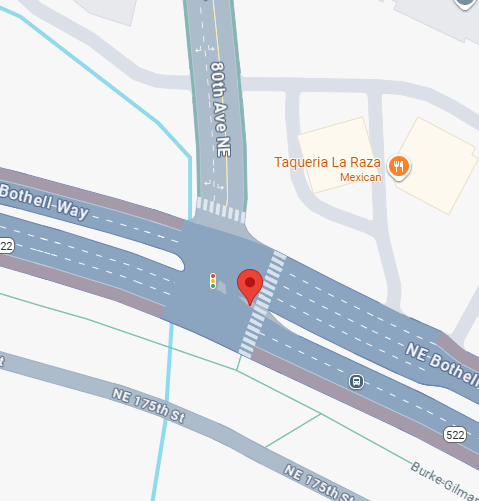

In [11]:
transformer2 = Transformer.from_crs(to_crs,from_crs)
e,n = transformer2.transform(lat,long)
print(e,n)

1213972.8318627405 888107.1310523641
